In [1]:
import numpy as np
from random import sample

# Custom modules
from preprocessing_post_fastsurfer.alignment import *
from preprocessing_post_fastsurfer.cropping import *
from preprocessing_post_fastsurfer.extraction import *
from preprocessing_post_fastsurfer.file_handling import *
from preprocessing_post_fastsurfer.mesh_creation import *
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *

np.set_printoptions(precision=2, suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Reference brain
Extract the brain from the MRI reference MRI for use in affine alginment

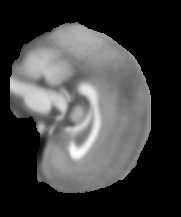

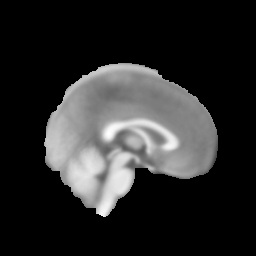

In [2]:
# NB seems that fastsrufer brain is better
reference_brain_array_mni = extract_brain("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/icbm_avg_152_t1_tal_lin.nii", "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/icbm_avg_152_t1_tal_lin_mask.nii")

display_array(reference_brain_array_mni)

reference_brain_array_fastsurfer = extract_brain("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/fastsurfer-processed/mri/orig_nu.mgz", "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/fastsurfer-processed/mri/mask.mgz")

display_array(reference_brain_array_fastsurfer)


## Main code

In [3]:
# Initialise a list of subject objects from the given directory
data_path = "/uolstore/home/users/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort"

subject_list = find_subjects_parallel(data_path)

print(len(subject_list))

# Chunk the subject list
def chunk_list(list, chunk_size):
    
    return [list[i:i + chunk_size] for i in range(0, len(list), chunk_size)]

chunks = chunk_list(subject_list, len(subject_list) // 5)


Csv files: ['/uolstore/home/users/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort/idaSearch_3_19_2025.csv']
543


In [ ]:
# Perform affine alignment on all subjects in the list, using the reference brain
alignment_parallel(subject_list, reference_brain_array_fastsurfer, display=True)

In [ ]:
# Crop all aligned brains to remove empty space
max_bbox = get_max_bbox(subject_list, 'brain_aligned.nii')

crop_subjects_parallel(subject_list, 'brain_aligned.nii', max_bbox, is_full_brain=True, display=True)

In [ ]:
# Align the parcellation file using the same affine transformation used on the brain
# NB affine alinged aparcs may be inaccurate
for chunk in chunks:
    
    aux_alignment_parallel(chunk, 'aparc', is_aparc=True)

In [ ]:
# Extract left and right hippocampus from non-aligned brains (in the same file)
for chunk in chunks:
    
    extract_region_parallel(chunk, [17, 53], 'orig_nu', 'aparc', is_aligned=False)

In [ ]:
# Crop hippocampi
max_bbox = get_max_bbox(subject_list, 'Left-Hippocampus_Right-Hippocampus.nii')

for chunk in chunks:
    
    crop_subjects_parallel(chunk, 'Left-Hippocampus_Right-Hippocampus.nii', max_bbox, is_full_brain=False)

In [ ]:
# Extract left and right hippocampus from aligned brains (in the same file)
for chunk in chunks:
    
    extract_region_parallel(chunk, [17, 53], 'brain_aligned', 'aparc_aligned', is_aligned=True)

In [ ]:
# Crop aligned hippocampi
max_bbox = get_max_bbox(subject_list, 'Left-Hippocampus_Right-Hippocampus_aligned.nii')

for chunk in chunks:
    
    crop_subjects_parallel(chunk, 'Left-Hippocampus_Right-Hippocampus_aligned.nii', max_bbox, is_full_brain=False)


In [ ]:
# Extract left hippocampus alone from non-aligned brains
for chunk in chunks:
    
    extract_region_parallel(chunk, [17], 'orig_nu', 'aparc', is_aligned=False)

In [ ]:
# Crop non-aligned left hippocampi
max_bbox = get_max_bbox(subject_list, 'Left-Hippocampus.nii')

for chunk in chunks:
    
    crop_subjects_parallel(chunk, 'Left-Hippocampus.nii', max_bbox, is_full_brain=False)

In [ ]:
# Extract left hippocampus alone from aligned brains
for chunk in chunks:
    
    extract_region_parallel(chunk, [17], 'brain_aligned', 'aparc_aligned', is_aligned=True)

In [ ]:
# Crop non-aligned left hippocampi
max_bbox = get_max_bbox(subject_list, 'Left-Hippocampus_aligned.nii')

for chunk in chunks:
    
    crop_subjects_parallel(chunk, 'Left-Hippocampus_aligned.nii', max_bbox, is_full_brain=False)

In [ ]:
# Convert cropped hippocampi point clouds using walking cubes method
volume_to_mesh_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_cropped.nii', display=False, smooth=True, number_of_iterations=5, lambda_filter=1.2)

In [ ]:
# Convert aligned cropped hippocampi point clouds using walking cubes method
volume_to_mesh_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_aligned_cropped.nii', display=False, smooth=True, number_of_iterations=5, lambda_filter=1.2)

In [ ]:
# Convert cropped hippocampi point clouds using walking cubes method
volume_to_mesh_parallel(subject_list, 'Left-Hippocampus_cropped.nii', display=False, smooth=True, number_of_iterations=5, lambda_filter=1.2)

In [ ]:
# Convert aligned cropped hippocampi point clouds using walking cubes method
volume_to_mesh_parallel(subject_list, 'Left-Hippocampus_aligned_cropped.nii', display=False, smooth=True, number_of_iterations=5, lambda_filter=1.2)

In [ ]:
# Delete all non-cropped hippocampi
for subject in subject_list:
    
    delete_file_matching(subject.path, 'Left-Hippocampus_Right-Hippocampus.nii')
    
    delete_file_matching(subject.path, 'Left-Hippocampus_Right-Hippocampus_aligned.nii')
    
    delete_file_matching(subject.path, 'Left-Hippocampus.nii')
    
    delete_file_matching(subject.path, 'Left-Hippocampus_aligned.nii')

In [ ]:
# Check minimum number of points in dataset such that we don't sample below
get_min_cloud_points(subject_list, 'Left-Hippocampus_Right-Hippocampus_cropped_mesh.npz')

In [ ]:
# Downsample all hippocampi clouds to have the same vector size for use in pytorch
downsample_cloud_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_cropped_mesh.npz', 2048, display=True)

In [ ]:
# Check minimum number of points in dataset such that we don't sample below
get_min_cloud_points(subject_list, 'Left-Hippocampus_Right-Hippocampus_aligned_cropped_mesh.npz')

In [ ]:
# Downsample all aligned hippocampi clouds to have the same vector size for use in pytorch
downsample_cloud_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_aligned_cropped_mesh.npz', 2048, display=True)

In [ ]:
# Check minimum number of points in dataset such that we don't sample below
get_min_cloud_points(subject_list, 'Left-Hippocampus_cropped_mesh.npz')

In [ ]:
# Downsample all hippocampi clouds to have the same vector size for use in pytorch
downsample_cloud_parallel(subject_list, 'Left-Hippocampus_cropped_mesh.npz', 1024, display=True)

In [ ]:
# Check minimum number of points in dataset such that we don't sample below
get_min_cloud_points(subject_list, 'Left-Hippocampus_aligned_cropped_mesh.npz')

In [ ]:
# Downsample all aligned hippocampi clouds to have the same vector size for use in pytorch
downsample_cloud_parallel(subject_list, 'Left-Hippocampus_aligned_cropped_mesh.npz', 1024, display=True)

In [19]:
# Visualise a subject
subject = sample(subject_list, 1)[0]
    
print(subject.path)


/uolstore/home/users/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort/ADNI_067_S_0098_MR_MPR__GradWarp__B1_Correction_Br_20070111013614241_S11324_I35921


MCI


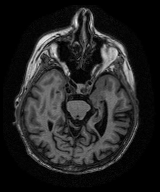

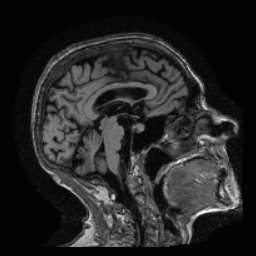

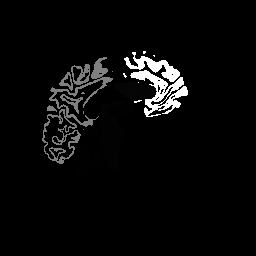

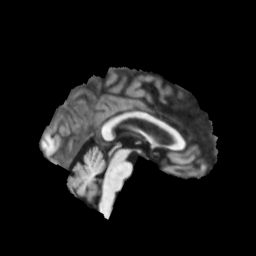

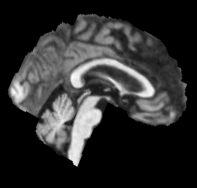

Widget(value='<iframe src="http://localhost:37815/index.html?ui=P_0x7f7dfab33f50_24&reconnect=auto" class="pyv…

Widget(value='<iframe src="http://localhost:37815/index.html?ui=P_0x7f7dfab331a0_25&reconnect=auto" class="pyv…

Widget(value='<iframe src="http://localhost:37815/index.html?ui=P_0x7f7df8915970_26&reconnect=auto" class="pyv…

In [20]:
research_group = subject.subject_metadata['Research Group'].iloc[0]

print(research_group)

display_image(nibabel.load(os.path.join(subject.path, 'mri/orig/001.mgz')), clip=True)

display_image(nibabel.load(subject.orig_nu), clip=True)

display_image(nibabel.load(subject.aparc), clip=True)

display_image(nibabel.load(subject.brain_aligned), clip=True)

display_image(nibabel.load(subject.brain_aligned_cropped), clip=True)

volume_to_mesh(subject, 'Left-Hippocampus_aligned_cropped.nii', smooth=False)

display_mesh(np.load(os.path.join(subject.path, 'Left-Hippocampus_aligned_cropped_mesh.npz')))
    
volume_to_mesh(subject, 'Left-Hippocampus_aligned_cropped.nii', smooth=True, number_of_iterations=5, lambda_filter=1.2)

display_mesh(np.load(os.path.join(subject.path, 'Left-Hippocampus_aligned_cropped_mesh.npz')))

display_cloud(np.load(os.path.join(subject.path, 'Left-Hippocampus_aligned_cropped_mesh_downsampledcloud.npy')))